## **We will analyse the various clusters in the Indeed job listing**

### **Import neccesary libraries**

In [46]:
#import ast
from gensim.models import Word2Vec, Doc2Vec
import nltk 
import numpy as np 
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd
from sklearn.cluster import KMeans 
from sklearn import cluster
from sklearn.neighbors import KDTree
from sklearn import metrics 
from sklearn.decomposition import PCA 
from scipy.cluster import hierarchy 
#from sklearn.cluster import AffinityPropagation
import re
from wordcloud import WordCloud, ImageColorGenerator
from itertools import cycle

from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

### **Upgrade packages if needed**

In [ ]:
!pip install gensim --upgrade
!pip install numpy --upgrade
!pip install scikit-learn --upgrade
!pip install scipy --upgrade
!pip install matplotlib --upgrade
!pip install tensorflow --upgrade

### **Upload dataset to Google Collab**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving job_scrapping_indeed.csv to job_scrapping_indeed.csv


### **Import the dataset**

In [3]:
import io
df_jobs = pd.read_csv(io.BytesIO(uploaded['job_scrapping_indeed.csv']))
# Dataset is now stored in a Pandas Dataframe

In [4]:
df_jobs.head()

,Unnamed: 0,job_title,company_name,description
0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...
1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...
2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...
3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...
4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...


### Downloading Transformers (Universal sentence encoder) the model

In [5]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


### Get embedding for the job descriptions

In [6]:
def get_embeddings(input):
  return model(input)

In [7]:
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = get_embeddings(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.008344486355781555, 0.00048085825983434916, 0.06595248728990555, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.050808604806661606, -0.01652429811656475, 0.01573782227933407, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.02833269163966179, -0.0558621808886528, -0.012941432185471058, ...]



In [9]:
df_jobs['job_embeddings'] = df_jobs.apply(lambda row: np.array(get_embeddings([row["description"]])).tolist()[0], axis=1)

In [10]:
df_jobs.head()

,Unnamed: 0,job_title,company_name,description,job_embeddings
0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...,"[-0.019656121730804443, -0.0417243093252182, 0..."
1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...,"[-0.04216742143034935, -0.05128977820277214, 0..."
2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...,"[-0.007637741509824991, -0.055372487753629684,..."
3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...,"[-0.028748871758580208, -0.05181778967380524, ..."
4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...,"[0.003560055047273636, -0.055286508053541183, ..."


**Clustering using Kmeans**

#### **Lets find the numbers of clusters using Kmeans**

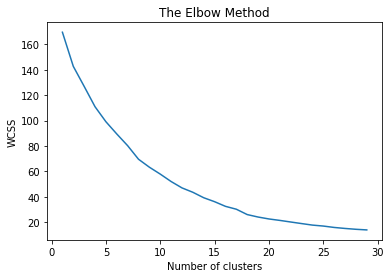

In [11]:
wcss = [] 

for i in range(1, 30): 
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 42 ) 
  kmeans.fit(df_jobs['job_embeddings'].tolist()) 
  wcss.append(kmeans.inertia_) 

plt.plot(range( 1,30), wcss) 
plt.title( 'The Elbow Method' ) 
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS') 
plt.show() 

**There is an elbow formed at 7 which means there are around 7 groups in the corpus. Lets go ahead with "7"**

In [59]:
kmeans_clustering = KMeans(n_clusters = 7, init='k-means++');
idx = kmeans_clustering.fit_predict(df_jobs['job_embeddings'].tolist())

In [60]:
cluster_labels_kmeans = pd.DataFrame(idx, columns=['ClusterLabel_kmeans'])
df_jobs_clustered_kmeans = pd.concat([df_jobs, cluster_labels_kmeans], axis=1)

In [80]:
df_jobs_clustered_kmeans.head()

,Unnamed: 0,job_title,company_name,description,job_embeddings,ClusterLabel_kmeans
0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...,"[-0.019656121730804443, -0.0417243093252182, 0...",5
1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...,"[-0.04216742143034935, -0.05128977820277214, 0...",5
2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...,"[-0.007637741509824991, -0.055372487753629684,...",1
3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...,"[-0.028748871758580208, -0.05181778967380524, ...",2
4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...,"[0.003560055047273636, -0.055286508053541183, ...",2


### **Wordcloud for each cluster**

In [62]:
centers = kmeans_clustering.cluster_centers_
clusters = idx
#centroid_map = dict(zip(w2v_model.wv.index2word, clusters));

**Creating a Word2Vec model for wordcloud**

In [47]:
# pre process the test.
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
def normalize_text(text):
    #text = re.sub("Selected intern's day-to-day responsibilities include:", "", text)    # remove common string from all jobs 
    regex = r"(\d(?:\.|\))\s+)|([a-z]\)\s+)|(•\s+)|([A-Z]\.\s+)|((?:[IVX]|[ivx])+(?:\.|\))\s+)"
    text = text.strip().replace("\n","")   # convert to lowercase
    text = re.sub(regex, "", text)                   # remove all bullet points
    words = text.split()                             # Filter out any stop words
    text_without_stops = ""
    for word in words:
      if not word in stop_words:
        text_without_stops = text_without_stops + word + " "
    return text_without_stops

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [48]:
tokenized_corpus = [normalize_text(df_jobs['description'][ind]).split(" ") for ind in df_jobs.index]

In [ ]:
tokenized_corpus

In [50]:
# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

#### **Get top 20 words in each cluster (20 words closest to the centroid)**

In [76]:
wpt = nltk.WordPunctTokenizer()
def get_top_tech_terms(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points]

    str_of_tech_terms = """ quantum computing algorithms prototype architecture model building rnn neural network aws artificial intelligence cnn R Python perl Java C++ 
     Ruby Perl Matlab JavaScript supervised unsupervised deploy nlp clustering chatbot dialogflow translation stacking
     Scala sqoop hive pig etl kafka Analytics Hadoop Spark olap oltp Visualization Deep Learning Computer Vision NLP MongoDB SQL 
     micro services hbase oops object oriented unix linux web mobile apps NoSQL Cassandra Tableau SAS mongo
     D3 Sagemaker Azure Google Cloud natural language processing scrapping machine mining structures server lead leader manage ann lstm recurrent 
     pipeline databricks azure solution architects engineers engineer data scientists scientist science ms bs phd masters bachelors
     factory warehouse warehousing teradata agile scrum """

    tokenized_tech_terms = wpt.tokenize(normalize_text(str_of_tech_terms))

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0] if index2word[j] in tokenized_tech_terms]
    #A DataFrame is generated from the dictionary.
    #df = pd.DataFrame(closest_words);
    #df.index = df.index+1

    return closest_words;

In [19]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
np.array(df_jobs['job_embeddings'].to_list()).shape

(502, 512)

In [77]:
closest_words = get_top_tech_terms(w2v_model.wv.index2word, 165, centers, np.array(df_jobs['job_embeddings'].to_list()));

In [78]:
def display_cloud(cluster_num, cmap):
  wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
  wordcloud = wc.generate(' '.join([word for word in closest_words['Cluster #' + str(cluster_num).zfill(2)]]))
  plt.figure()
  plt.imshow(wordcloud)
  plt.axis("off")
  #plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

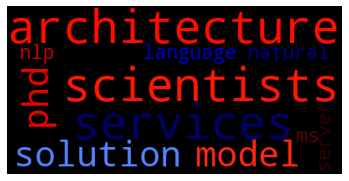

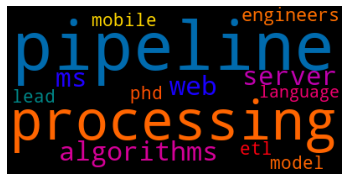

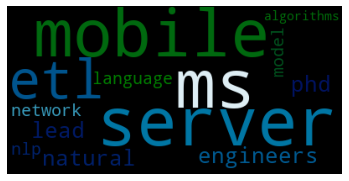

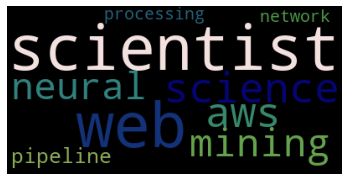

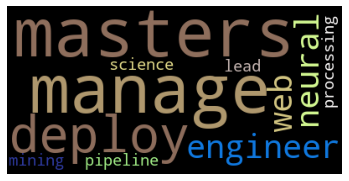

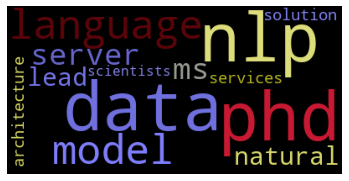

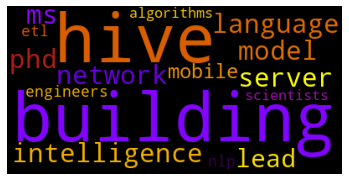

In [79]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar', 'flag'])
for i in range(7):
    col = next(cmaps);
    display_cloud(i, col)

In [ ]:
df_jobs_clustered_kmeans.to_csv("job_clustering_indeed.csv", encoding="utf-8")